In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import torch
import torchvision.transforms as transforms
import glob
import torchvision
import time
import random
from PIL import Image
from torch.utils.data import DataLoader, Dataset

In [ ]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torchvision.transforms import RandomChoice

ROOT_DIR_TRAIN = "/content/drive/MyDrive/PlantDoc-Dataset/train"
ROOT_DIR_TEST = "/content/drive/MyDrive/PlantDoc-Dataset/test"

# Transforms for training with Random Erase
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Transforms for validation/testing
test_valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Prepare the Dataset
dataset_train = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=train_transform)
dataset_valid = datasets.ImageFolder(root=ROOT_DIR_TRAIN, transform=test_valid_transform)
test_dataset = datasets.ImageFolder(root=ROOT_DIR_TEST, transform=test_valid_transform)

train_size = int(0.80 * len(dataset_train))
valid_size = len(dataset_train) - train_size

# Radomize the data indices.
indices = torch.randperm(len(dataset_train)).tolist()
# Training and validation sets.
train_dataset = Subset(dataset_train, indices[:-valid_size])
valid_dataset = Subset(dataset_valid, indices[-valid_size:])

# Prepare the Data Loaderscollate_fn=collate_fn
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

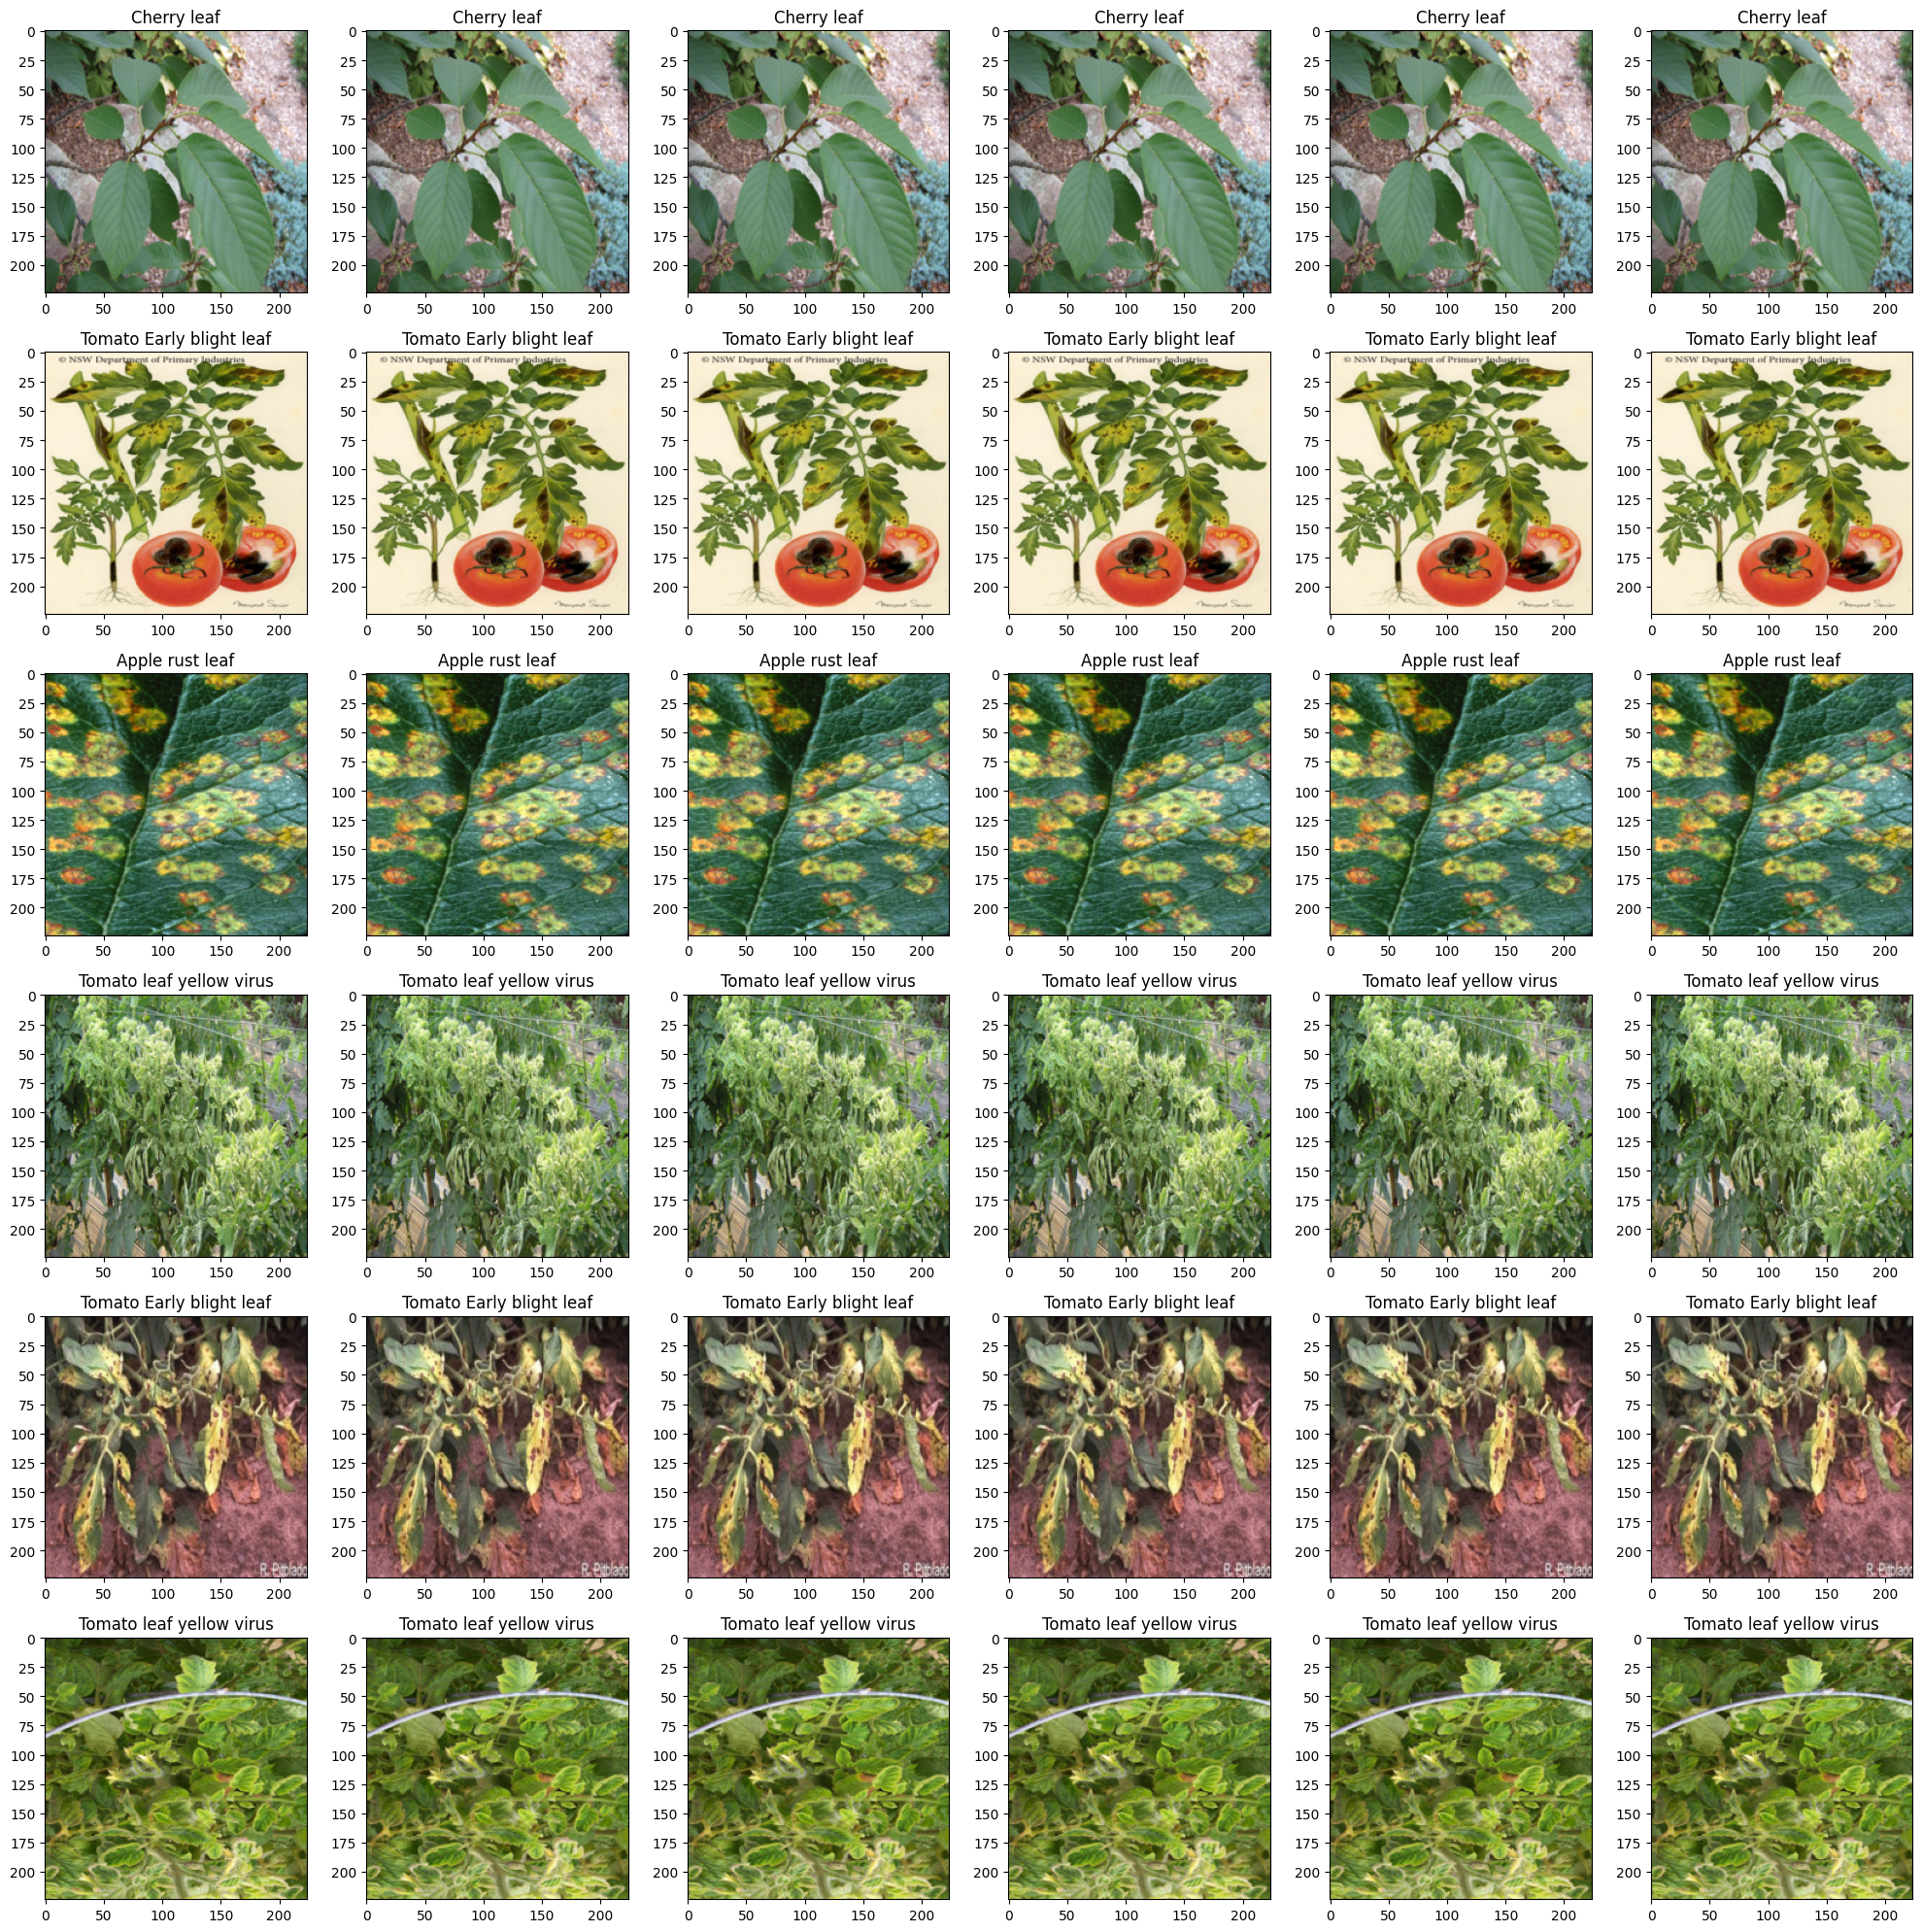

In [ ]:
def show_dataset(dataset_train, n=6):
    fig, axs = plt.subplots(n, n, figsize=(20, 20))

    for row in range(n):
        idx = np.random.randint(len(dataset_train))  # select the same index for each row
        for col in range(n):
            image, label = dataset_train[idx]
            image = image.permute(1, 2, 0)  # CxHxW -> HxWxC
            image = image * torch.Tensor([0.229, 0.224, 0.225]) + torch.Tensor([0.485, 0.456, 0.406])  # denormalize
            image = (image * 255).byte().numpy()  # convert to uint8 numpy array
            axs[row, col].imshow(image)
            axs[row, col].set_title(dataset_train.classes[label])
            axs[row, col].axis()

    plt.tight_layout()
    plt.show()

# Show Dataset
show_dataset(dataset_train)

In [ ]:
from torchvision import models
dir(models)

['AlexNet',
 'AlexNet_Weights',
 'ConvNeXt',
 'ConvNeXt_Base_Weights',
 'ConvNeXt_Large_Weights',
 'ConvNeXt_Small_Weights',
 'ConvNeXt_Tiny_Weights',
 'DenseNet',
 'DenseNet121_Weights',
 'DenseNet161_Weights',
 'DenseNet169_Weights',
 'DenseNet201_Weights',
 'EfficientNet',
 'EfficientNet_B0_Weights',
 'EfficientNet_B1_Weights',
 'EfficientNet_B2_Weights',
 'EfficientNet_B3_Weights',
 'EfficientNet_B4_Weights',
 'EfficientNet_B5_Weights',
 'EfficientNet_B6_Weights',
 'EfficientNet_B7_Weights',
 'EfficientNet_V2_L_Weights',
 'EfficientNet_V2_M_Weights',
 'EfficientNet_V2_S_Weights',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'GoogLeNet_Weights',
 'Inception3',
 'InceptionOutputs',
 'Inception_V3_Weights',
 'MNASNet',
 'MNASNet0_5_Weights',
 'MNASNet0_75_Weights',
 'MNASNet1_0_Weights',
 'MNASNet1_3_Weights',
 'MaxVit',
 'MaxVit_T_Weights',
 'MobileNetV2',
 'MobileNetV3',
 'MobileNet_V2_Weights',
 'MobileNet_V3_Large_Weights',
 'MobileNet_V3_Small_Weights',
 'RegNet',
 'RegNet_X_16GF_Weights'

In [ ]:
!pip install torchinfo

In [ ]:
import torch.nn as nn
from torchinfo import summary
from torchvision import models

# Load a pre-trained vit model
vit_model = models.vit_b_16(pretrained=True)

# Set the number of classes to match your dataset
num_classes = 27

# Modify the fully connected layer to match the number of classes
vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, num_classes)

# Set the device (CPU or GPU)
vit_model.to(device)

# Display the model summary
summary(vit_model, input_size=(1, 3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [01:12<00:00, 4.79MB/s]


Layer (type:depth-idx)                        Output Shape              Param #
VisionTransformer                             [1, 27]                   768
├─Conv2d: 1-1                                 [1, 768, 14, 14]          590,592
├─Encoder: 1-2                                [1, 197, 768]             151,296
│    └─Dropout: 2-1                           [1, 197, 768]             --
│    └─Sequential: 2-2                        [1, 197, 768]             --
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-4                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-5                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-6                 [1, 197, 768]             7,087,872
│    │    └─EncoderBlock: 3-7             

In [ ]:
import torch.optim as optim
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, Subset
import numpy as np

def train_model(model, criterion, optimizer, dataloader, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

def validate_model(model, criterion, dataloader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
def test_model(model, criterion, test_loader, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects.double() / len(test_loader.dataset)

    return epoch_loss, epoch_acc

In [ ]:
# Set the number of folds
num_folds = 5

# Prepare the data
X = np.arange(len(dataset_train))
y = np.array([label for _, label in dataset_valid.imgs])

# Set up the StratifiedKFold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Set device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize lists to store fold results
fold_train_losses = []
fold_valid_losses = []
fold_test_losses = []
fold_train_accs = []
fold_valid_accs = []
fold_test_accs = []

for fold, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Create data loaders for the current fold
    train_data = Subset(dataset_train, train_index)
    valid_data = Subset(dataset_valid, valid_index)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
    valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

    # Load and prepare the model
    vit_model = models.vit_b_16(pretrained=True)
    vit_model.heads.head = nn.Linear(vit_model.heads.head.in_features, num_classes)
    vit_model.to(device)

    # Set the criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(vit_model.parameters(), lr=0.001, momentum=0.9)

    # Train and validate the model
    num_epochs = 50
    epoch_train_losses = []
    epoch_valid_losses = []
    epoch_test_losses = []
    epoch_train_accs = []
    epoch_valid_accs = []
    epoch_test_accs = []
    for epoch in range(num_epochs):
        train_loss, train_acc = train_model(vit_model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = validate_model(vit_model, criterion, valid_loader, device)
        test_loss, test_acc = test_model(vit_model, criterion, test_loader, device)

        epoch_train_losses.append(train_loss)
        epoch_valid_losses.append(valid_loss)
        epoch_test_losses.append(test_loss)
        epoch_train_accs.append(train_acc)
        epoch_valid_accs.append(valid_acc)
        epoch_test_accs.append(test_acc)

        print(f"Epoch {epoch + 1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f} Train Accuracy: {train_acc * 100:.4f} "
              f"Valid Loss: {valid_loss:.4f} Valid Accuracy: {valid_acc * 100:.4f} "
              f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc * 100:.4f}")

    fold_train_losses.append(epoch_train_losses)
    fold_valid_losses.append(epoch_valid_losses)
    fold_test_losses.append(epoch_test_losses)
    fold_train_accs.append(epoch_train_accs)
    fold_valid_accs.append(epoch_valid_accs)
    fold_test_accs.append(epoch_test_accs)

    print("Finished Fold")
    print("=" * 50)

Fold 1/5


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50: Train Loss: 2.8712 Train Accuracy: 20.4644 Valid Loss: 2.3413 Valid Accuracy: 37.2845 Test Loss: 2.5323 Test Accuracy: 28.8136
Epoch 2/50: Train Loss: 1.7944 Train Accuracy: 50.8639 Valid Loss: 1.6925 Valid Accuracy: 50.8621 Test Loss: 1.8649 Test Accuracy: 43.2203
Epoch 3/50: Train Loss: 1.1916 Train Accuracy: 69.4924 Valid Loss: 1.4226 Valid Accuracy: 54.3103 Test Loss: 1.5436 Test Accuracy: 50.8475
Epoch 4/50: Train Loss: 0.8138 Train Accuracy: 80.2376 Valid Loss: 1.3142 Valid Accuracy: 57.3276 Test Loss: 1.3330 Test Accuracy: 58.0508
Epoch 5/50: Train Loss: 0.5554 Train Accuracy: 88.9309 Valid Loss: 1.2690 Valid Accuracy: 59.6983 Test Loss: 1.2982 Test Accuracy: 55.5085
Epoch 6/50: Train Loss: 0.3635 Train Accuracy: 94.7624 Valid Loss: 1.2873 Valid Accuracy: 57.5431 Test Loss: 1.3336 Test Accuracy: 55.9322
Epoch 7/50: Train Loss: 0.2298 Train Accuracy: 97.7322 Valid Loss: 1.2706 Valid Accuracy: 60.9914 Test Loss: 1.2439 Test Accuracy: 60.1695
Epoch 8/50: Train Loss: 0.1

In [ ]:
# Evaluate the trained model on the training and validation sets for each fold.
avg_train_acc_k_folds = []
avg_val_acc_k_folds = []

def evaluate_accuracy(history, index):
    history_cpu = [item.cpu() for item in history]
    return sum(history_cpu) / len(history_cpu)

for i in range(num_folds):
    train_accuracy = evaluate_accuracy(fold_train_accs[i], 2)
    valid_accuracy = evaluate_accuracy(fold_valid_accs[i], 3)
    print(f'Fold {i + 1}/{num_folds}:')
    print(f'\tTraining Accuracy: {train_accuracy * 100:.2f}%')
    print(f'\tValidation Accuracy: {valid_accuracy * 100:.2f}%')
    avg_train_acc_k_folds.append(train_accuracy)
    avg_val_acc_k_folds.append(valid_accuracy)

# Compute the average training and validation accuracy over all folds.
overall_train_acc = sum(avg_train_acc_k_folds) / len(avg_train_acc_k_folds)
overall_val_acc = sum(avg_val_acc_k_folds) / len(avg_val_acc_k_folds)

# Calculate the average and standard deviation of the training and validation accuracy over all folds.
avg_train_acc = np.mean(avg_train_acc_k_folds)
std_train_acc = np.std(avg_train_acc_k_folds)
avg_val_acc = np.mean(avg_val_acc_k_folds)
std_val_acc = np.std(avg_val_acc_k_folds)

# Print the average and standard deviation of the training and validation accuracy over all folds.
print(f'\nAverage Training Accuracy over {num_folds}-fold Cross Validation: {avg_train_acc * 100:.2f}% +/- {std_train_acc * 100:.2f}%')
print(f'Average Validation Accuracy over {num_folds}-fold Cross Validation: {avg_val_acc * 100:.2f}% +/- {std_val_acc * 100:.2f}%')

Fold 1/5:
	Training Accuracy: 95.22%
	Validation Accuracy: 57.32%
Fold 2/5:
	Training Accuracy: 95.69%
	Validation Accuracy: 60.96%
Fold 3/5:
	Training Accuracy: 95.60%
	Validation Accuracy: 58.66%
Fold 4/5:
	Training Accuracy: 95.42%
	Validation Accuracy: 62.44%
Fold 5/5:
	Training Accuracy: 95.12%
	Validation Accuracy: 60.15%

Average Training Accuracy over 5-fold Cross Validation: 95.41% +/- 0.22%
Average Validation Accuracy over 5-fold Cross Validation: 59.90% +/- 1.78%


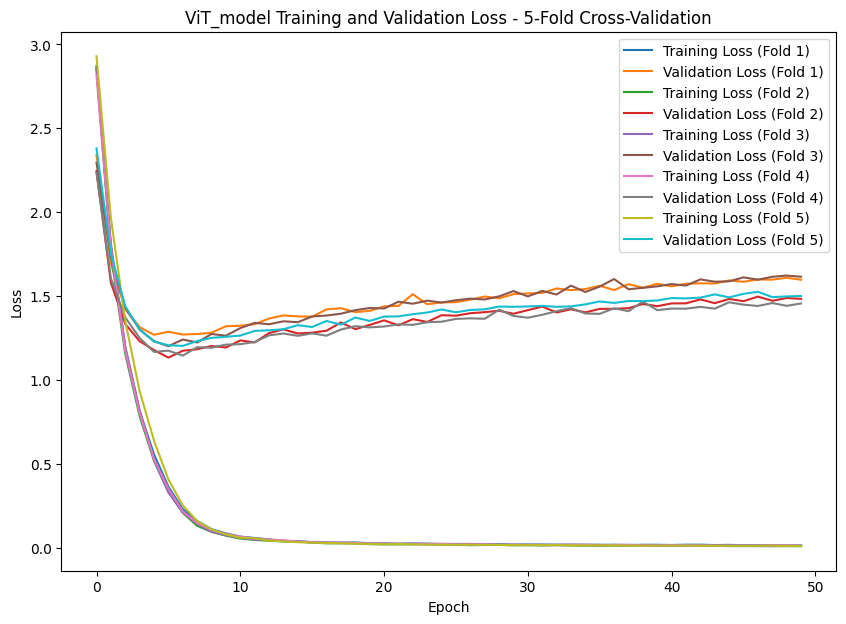

In [ ]:
# Plot the training and validation loss for each epoch
model_name = "ViT_model"
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(fold_train_losses[fold], label=f'Training Loss (Fold {fold+1})')
    plt.plot(fold_valid_losses[fold], label=f'Validation Loss (Fold {fold+1})')

plt.title(f'{model_name} Training and Validation Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

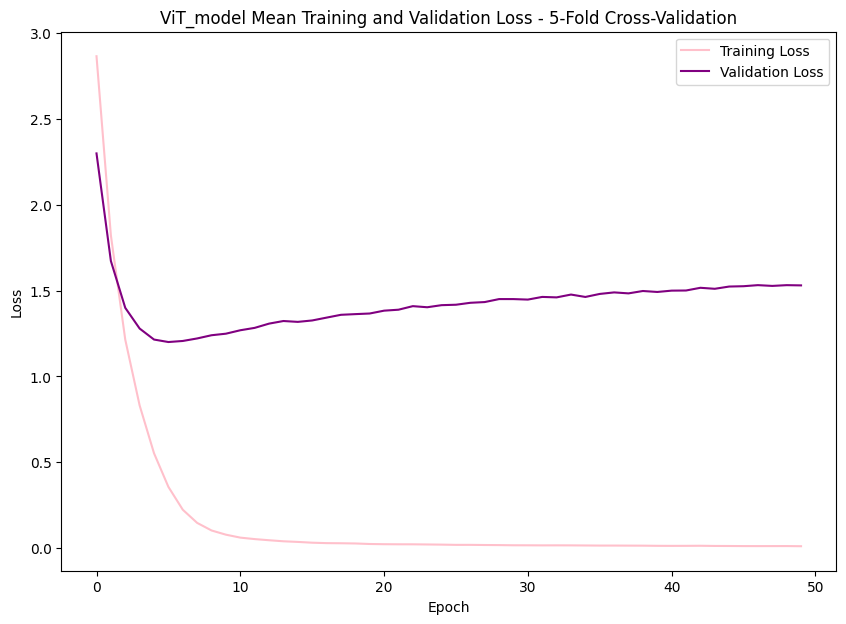

In [ ]:
# Compute mean loss across all folds at each epoch
train_loss_mean = np.mean([np.array(fold_train_losses[i]) for i in range(num_folds)], axis=0)
valid_loss_mean = np.mean([np.array(fold_valid_losses[i]) for i in range(num_folds)], axis=0)

# Plot mean loss history
plt.figure(figsize=(10, 7))
plt.plot(train_loss_mean, label='Training Loss', color='pink')
plt.plot(valid_loss_mean, label='Validation Loss', color='purple')
plt.title(f'{model_name} Mean Training and Validation Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

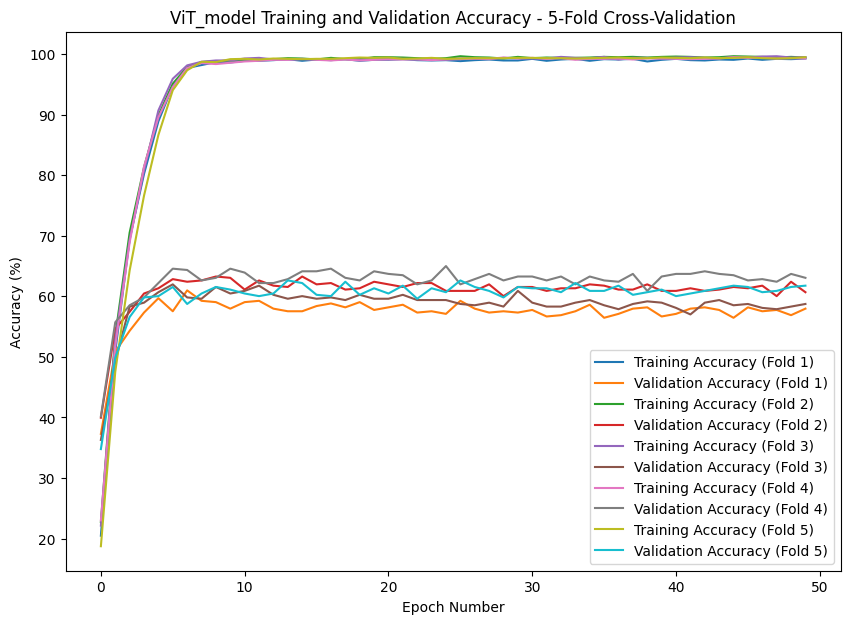

In [ ]:
# Plot the training and validation accuracy for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(np.array([acc.cpu() for acc in fold_train_accs[fold]]) * 100, label=f'Training Accuracy (Fold {fold+1})')
    plt.plot(np.array([acc.cpu() for acc in fold_valid_accs[fold]]) * 100, label=f'Validation Accuracy (Fold {fold+1})')

plt.title(f'{model_name} Training and Validation Accuracy - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

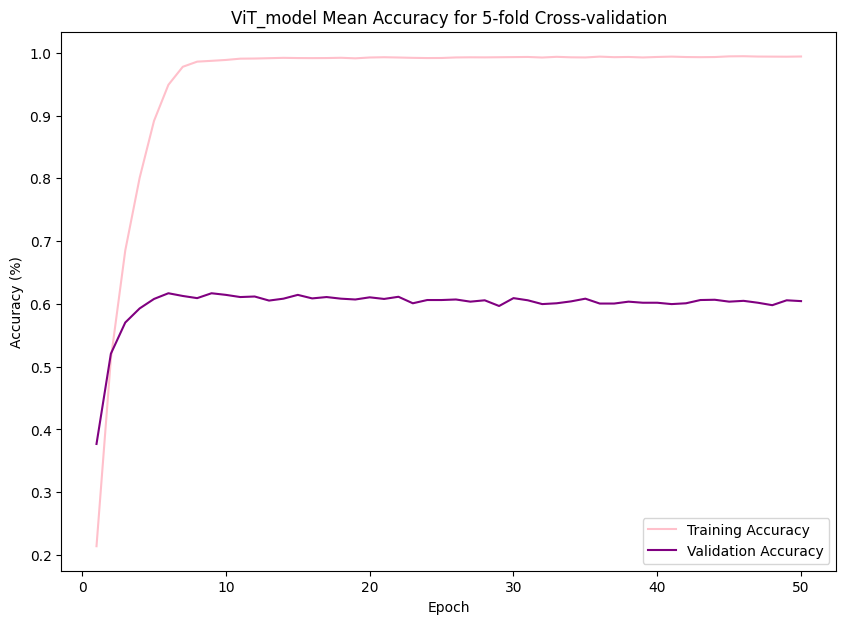

In [ ]:
# Compute mean accuracy across all folds at each epoch
train_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_train_accs[i]]) for i in range(num_folds)], axis=0)
valid_acc_mean = np.mean([np.array([acc.cpu() for acc in fold_valid_accs[i]]) for i in range(num_folds)], axis=0)

# Plot mean accuracy history
plt.figure(figsize=(10, 7))
plt.plot(np.arange(1, num_epochs + 1), train_acc_mean, label='Training Accuracy', color='pink')
plt.plot(np.arange(1, num_epochs + 1), valid_acc_mean, label='Validation Accuracy', color='purple')
plt.title(f'{model_name} Mean Accuracy for {num_folds}-fold Cross-validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
# Evaluate the trained model on the test sets for each fold.
avg_test_acc_k_folds = []

def evaluate_accuracy(history, index):
    history_cpu = [item.cpu() for item in history]
    return sum(history_cpu) / len(history_cpu)

for i in range(num_folds):
    test_accuracy = evaluate_accuracy(fold_test_accs[i], 2)
    print(f'Fold {i + 1}/{num_folds}:')
    print(f'\tTest Accuracy: {test_accuracy * 100:.2f}%')
    avg_test_acc_k_folds.append(test_accuracy)

# Compute the average test accuracy over all folds.
overall_test_acc = sum(avg_test_acc_k_folds) / len(avg_test_acc_k_folds)

# Calculate the average and standard deviation of the test accuracy over all folds.
avg_test_acc = np.mean(avg_test_acc_k_folds)
std_test_acc = np.std(avg_test_acc_k_folds)

# Print the average and standard deviation of the test accuracy over all folds.
print(f'\nAverage Test Accuracy over {num_folds}-fold Cross Validation: {avg_test_acc * 100:.2f}% +/- {std_test_acc * 100:.2f}%')

Fold 1/5:
	Test Accuracy: 59.19%
Fold 2/5:
	Test Accuracy: 59.24%
Fold 3/5:
	Test Accuracy: 58.58%
Fold 4/5:
	Test Accuracy: 57.42%
Fold 5/5:
	Test Accuracy: 54.04%

Average Test Accuracy over 5-fold Cross Validation: 57.70% +/- 1.94%


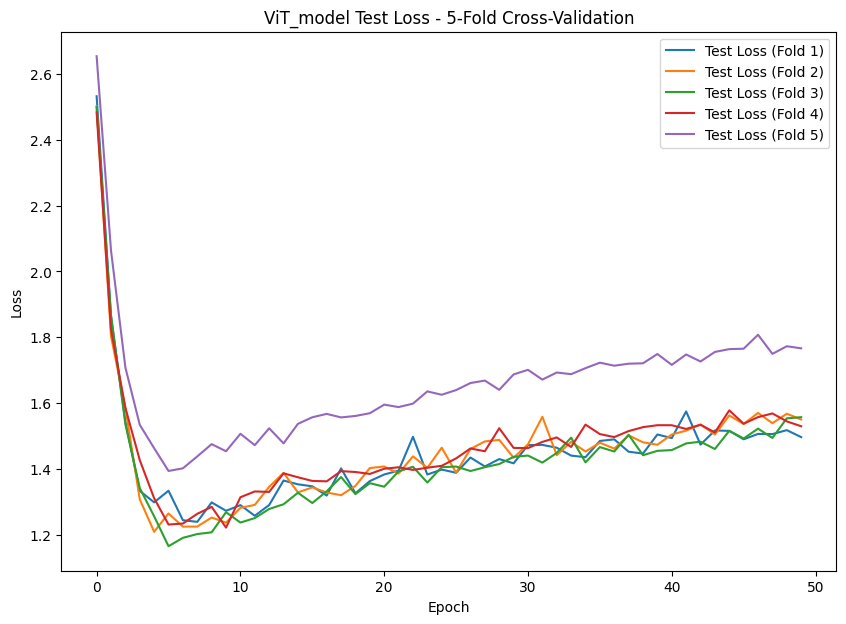

In [ ]:
# Plot the test loss for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(fold_test_losses[fold], label=f'Test Loss (Fold {fold+1})')

plt.title(f'{model_name} Test Loss - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

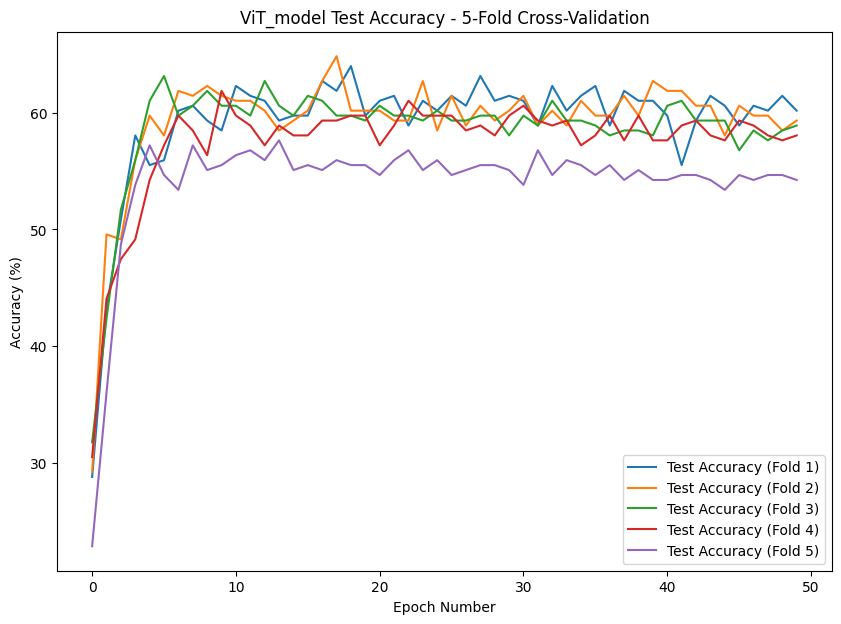

In [ ]:
# Plot the test accuracy for each epoch
plt.figure(figsize=(10, 7))
for fold in range(num_folds):
    plt.plot(np.array([acc.cpu() for acc in fold_test_accs[fold]]) * 100, label=f'Test Accuracy (Fold {fold+1})')

plt.title(f'{model_name} Test Accuracy - {num_folds}-Fold Cross-Validation')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
print("Classes: ")
class_names = test_dataset.classes
print(test_dataset.classes)

Classes: 
['Apple Scab Leaf', 'Apple leaf', 'Apple rust leaf', 'Bell_pepper leaf', 'Bell_pepper leaf spot', 'Blueberry leaf', 'Cherry leaf', 'Corn Gray leaf spot', 'Corn leaf blight', 'Corn rust leaf', 'Peach leaf', 'Potato leaf early blight', 'Potato leaf late blight', 'Raspberry leaf', 'Soyabean leaf', 'Squash Powdery mildew leaf', 'Strawberry leaf', 'Tomato Early blight leaf', 'Tomato Septoria leaf spot', 'Tomato leaf', 'Tomato leaf bacterial spot', 'Tomato leaf late blight', 'Tomato leaf mosaic virus', 'Tomato leaf yellow virus', 'Tomato mold leaf', 'grape leaf', 'grape leaf black rot']


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# สมมุติว่า `model` คือโมเดลที่คุณได้ทำการฝึกฝนเสร็จสิ้นแล้ว
# และ `test_loader` คือ DataLoader สำหรับข้อมูลทดสอบ

all_labels, all_preds = [], []
for inputs, labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = vit_model(inputs)
        _, preds = torch.max(outputs, 1)

    all_labels.extend(labels.tolist())
    all_preds.extend(preds.tolist())

# พิมพ์ confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[8 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 6 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 7 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0]
 [0 0 0 4 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 1 3 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1]
 [1 2 0 0 0 5 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 3 0 0 0 3 2 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 9 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 1 0 0 1 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 2 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 3 3 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 6 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [1 2 0 0 0 0 0 0 0 0 0 0 0 1 3 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 1 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 8 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 

In [ ]:
# พิมพ์ classification report ซึ่งจะบอก precision, recall และ F1-score
report = classification_report(all_labels, all_preds, target_names=class_names)
print("Classification Report:\n", report)

Classification Report:
                             precision    recall  f1-score   support

           Apple Scab Leaf       0.73      0.80      0.76        10
                Apple leaf       0.35      0.67      0.46         9
           Apple rust leaf       0.78      0.70      0.74        10
          Bell_pepper leaf       0.57      0.50      0.53         8
     Bell_pepper leaf spot       0.50      0.33      0.40         9
            Blueberry leaf       0.50      0.45      0.48        11
               Cherry leaf       0.67      0.20      0.31        10
       Corn Gray leaf spot       0.30      0.75      0.43         4
          Corn leaf blight       0.75      0.50      0.60        12
            Corn rust leaf       0.90      0.90      0.90        10
                Peach leaf       0.56      0.56      0.56         9
  Potato leaf early blight       0.25      0.25      0.25         8
   Potato leaf late blight       0.38      0.38      0.38         8
            Raspberry l

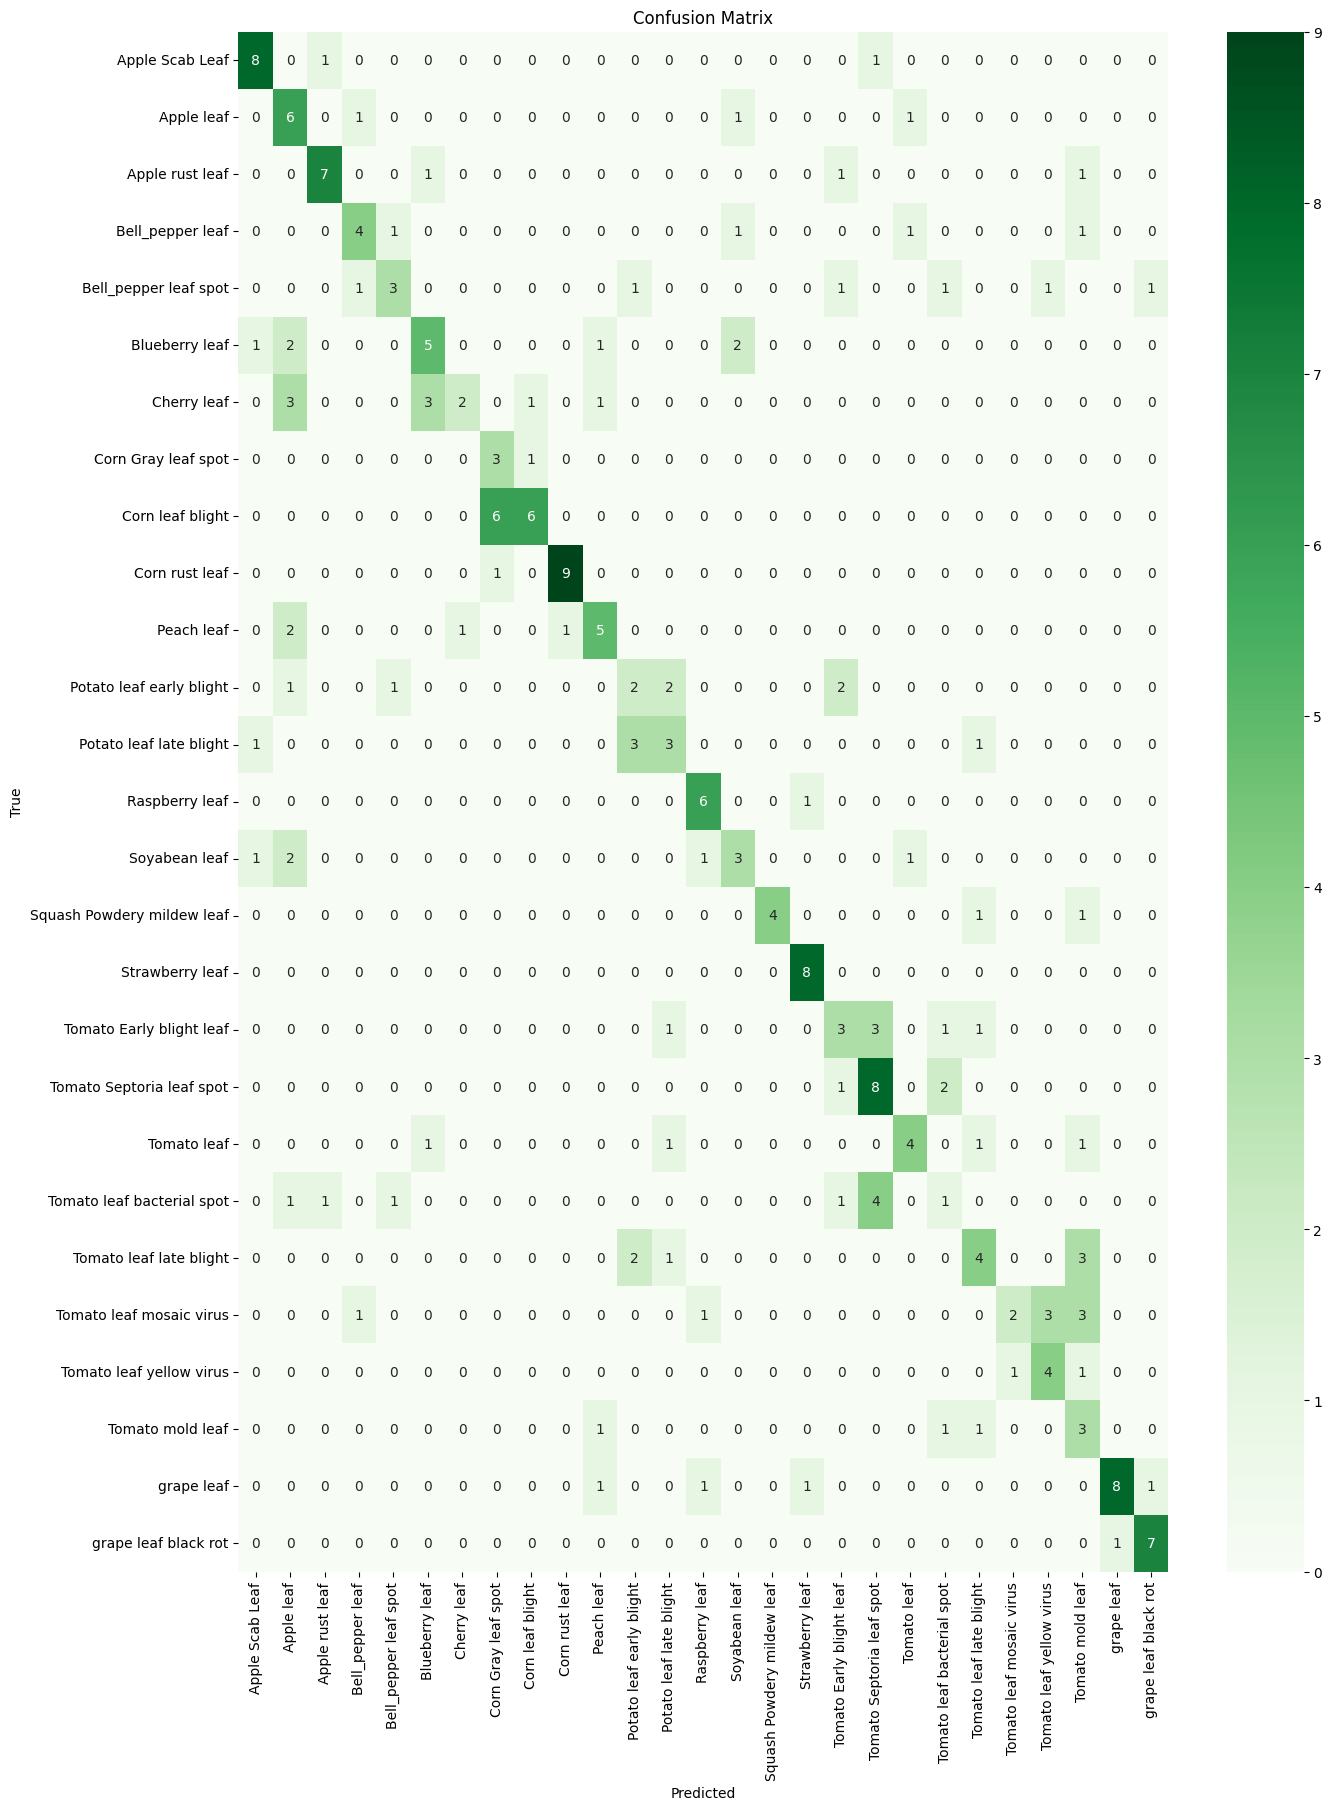

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(15, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

<ipython-input-27-af32650244a3>:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm_total = cm.astype(np.float).sum(axis=1)


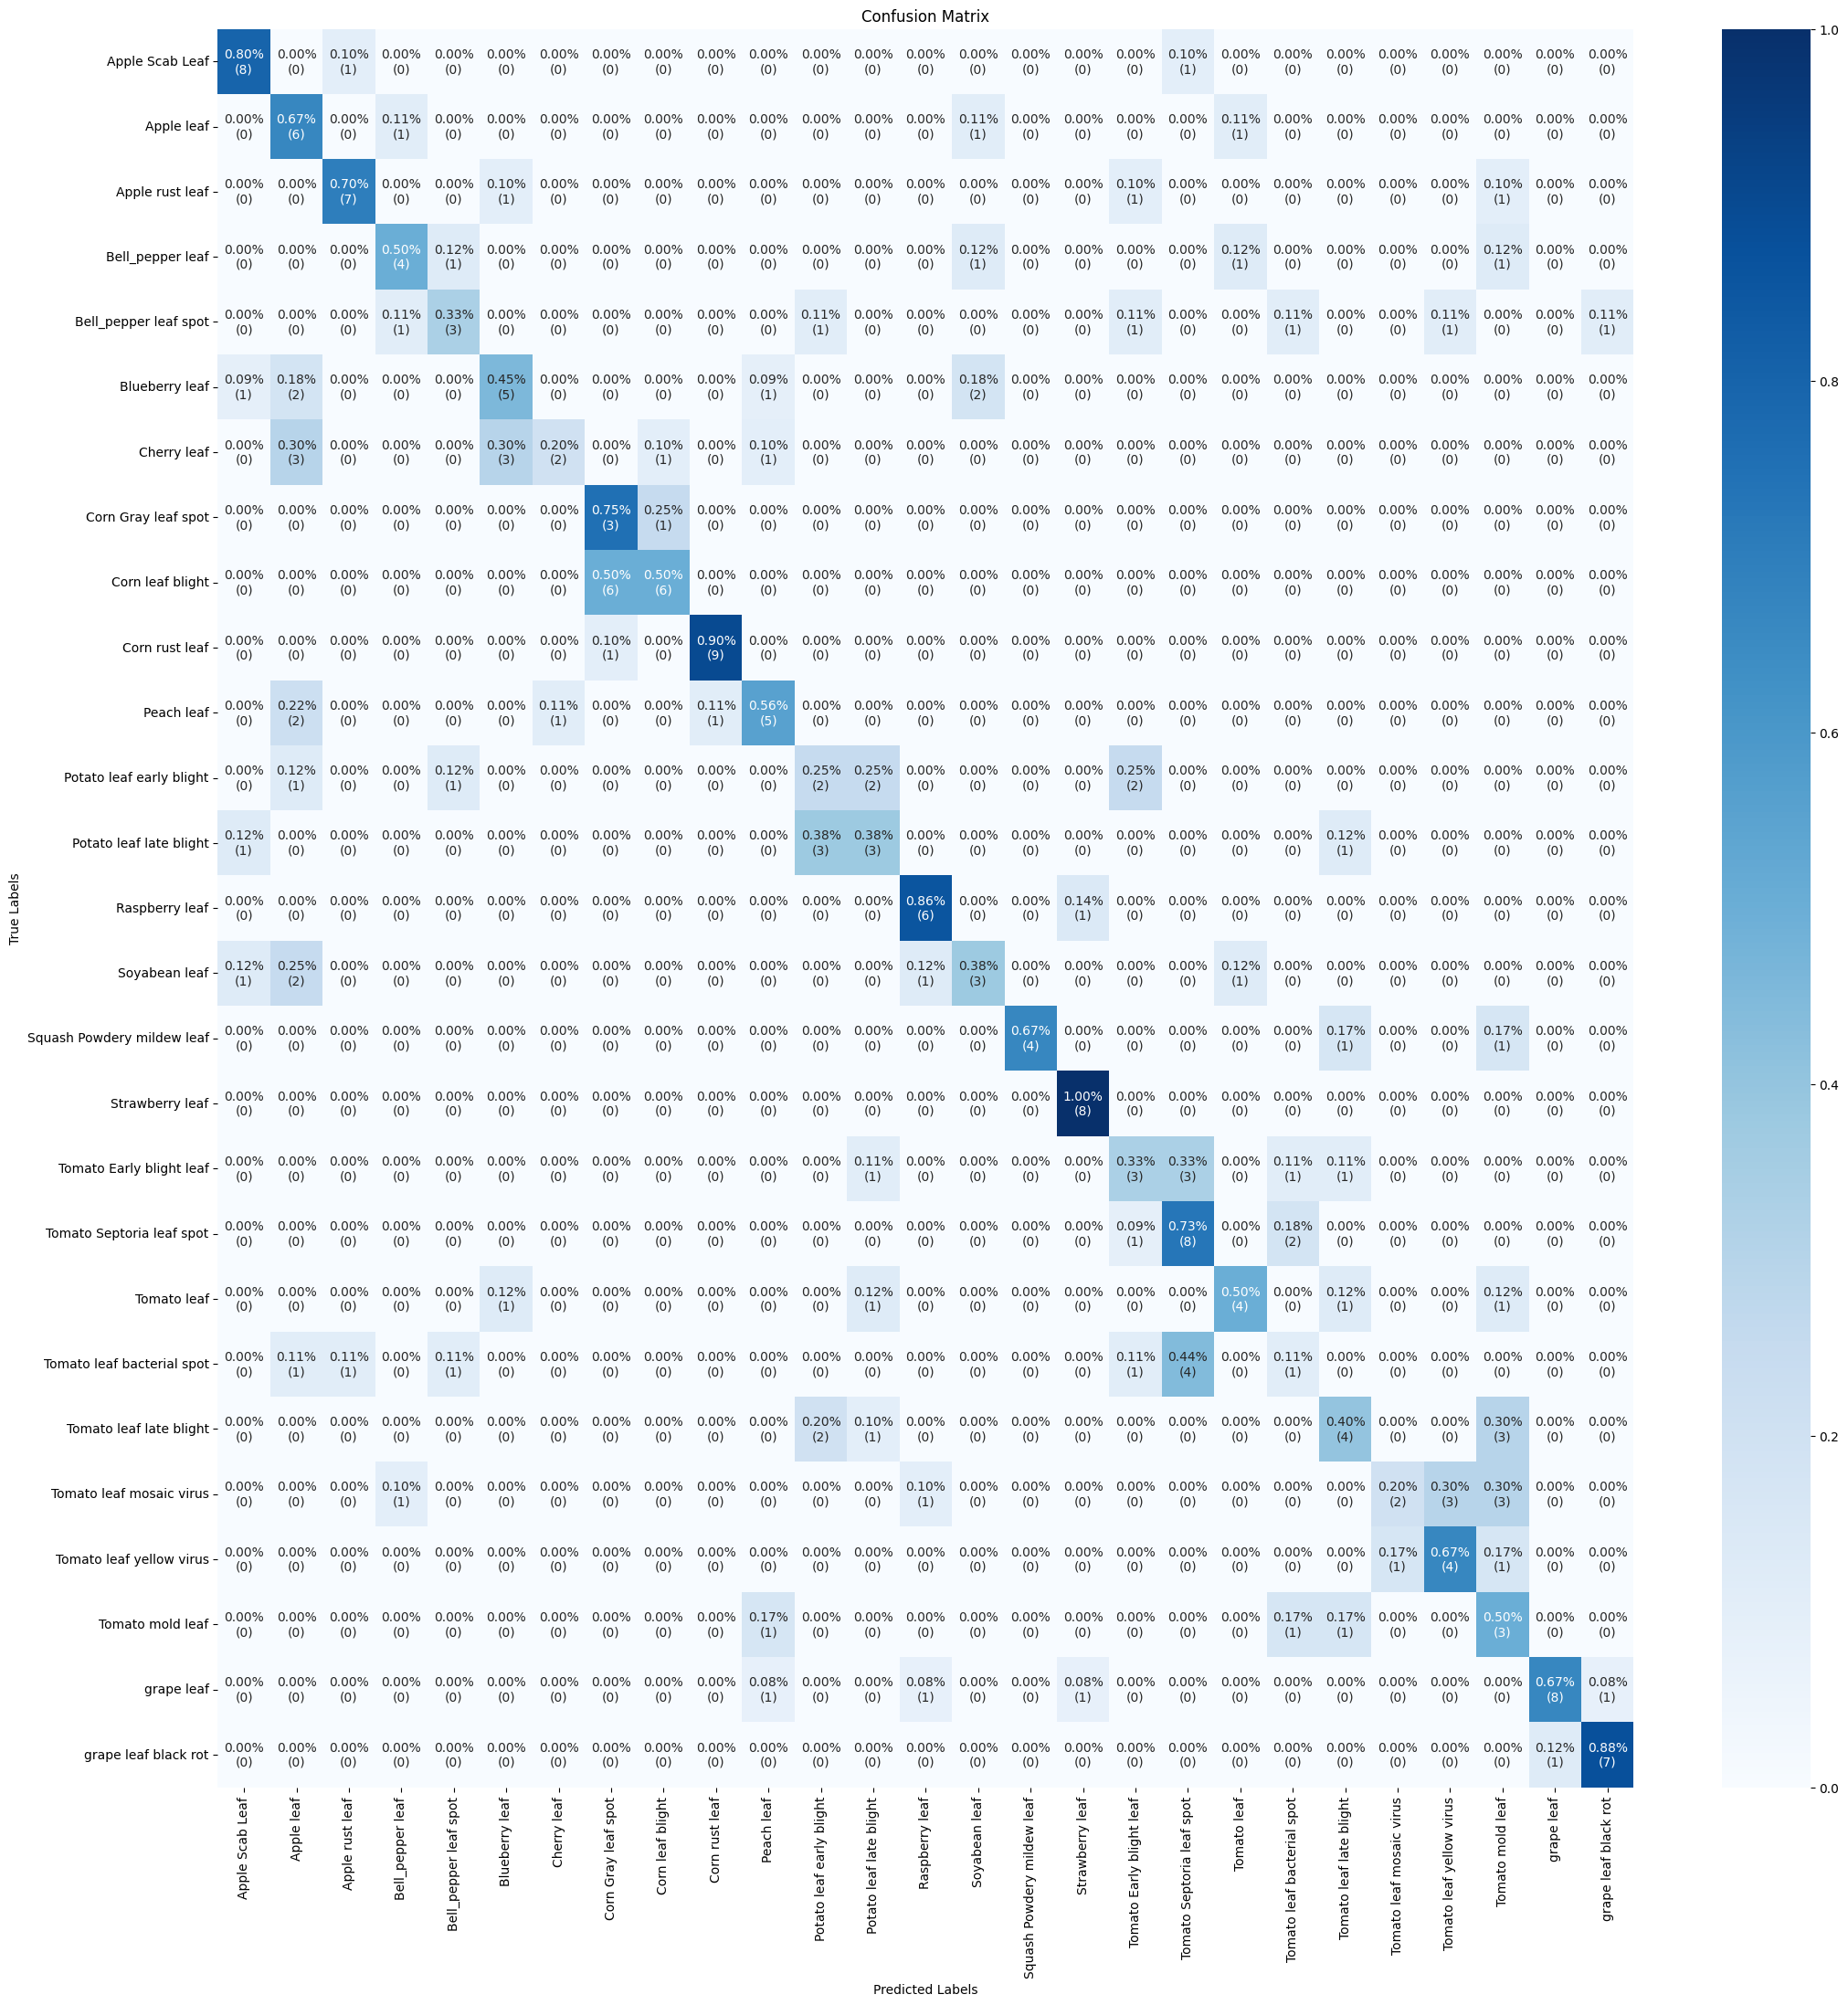

In [ ]:
def fmt(p, total):
    return '{:.2f}%\n({:.0f})'.format(p, total)

# Compute normalized confusion matrix
cm_total = cm.astype(np.float).sum(axis=1)
cm_normalized = cm.astype('float') / cm_total[:, np.newaxis]

# Compute annotations
annotations = np.vectorize(fmt)(cm_normalized, cm)

fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(cm_normalized, annot=annotations, fmt='', cmap='Blues', ax=ax,
            xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

plt.show()

In [ ]:
correct_samples = {class_name: [] for class_name in class_names}
incorrect_samples = {class_name: [] for class_name in class_names}

vit_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = vit_model(inputs)
        _, preds = torch.max(outputs, 1)
        scores = torch.nn.functional.softmax(outputs, dim=1) * 100 # compute softmax scores

        # Iterate over the batch
        for input_image, true_label, pred_label, score in zip(inputs, labels, preds, scores):
            class_name = class_names[true_label.item()]
            if true_label == pred_label:
                # Correct prediction
                correct_samples[class_name].append((input_image.cpu(), score[pred_label.item()].item()))
            else:
                # Incorrect prediction
                incorrect_samples[class_name].append((input_image.cpu(), class_names[pred_label.item()], score[pred_label.item()].item()))

In [ ]:
def imshow(ax, inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title, fontsize=12)

# Create separate grid for each class
for i, class_name in enumerate(class_names):
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    for j in range(5):
        if j < len(correct_samples[class_name]):
            imshow(axes[0, j], correct_samples[class_name][j][0], title=f"Pred: {class_name}\nTrue: {class_name}\nScore: {correct_samples[class_name][j][1]:.4f}%")
        else:  # In case we don't have enough correct samples
            axes[0, j].axis('off')

        if j < len(incorrect_samples[class_name]):
            imshow(axes[1, j], incorrect_samples[class_name][j][0], title=f"Pred: {incorrect_samples[class_name][j][1]}\nTrue: {class_name}\nScore: {incorrect_samples[class_name][j][2]:.4f}%")
        else:  # In case we don't have enough incorrect samples
            axes[1, j].axis('off')

    axes[0, 0].set_ylabel("Correct samples")
    axes[1, 0].set_ylabel("Incorrect samples")

    # Add class name as a big title for each class
    fig.suptitle(class_name, fontsize=16)

    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38243 sha256=c468a6355290c63276c4a96a1668b6cef84f325984d199dd075070e7ec58dd8e
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


AxisError: ignored

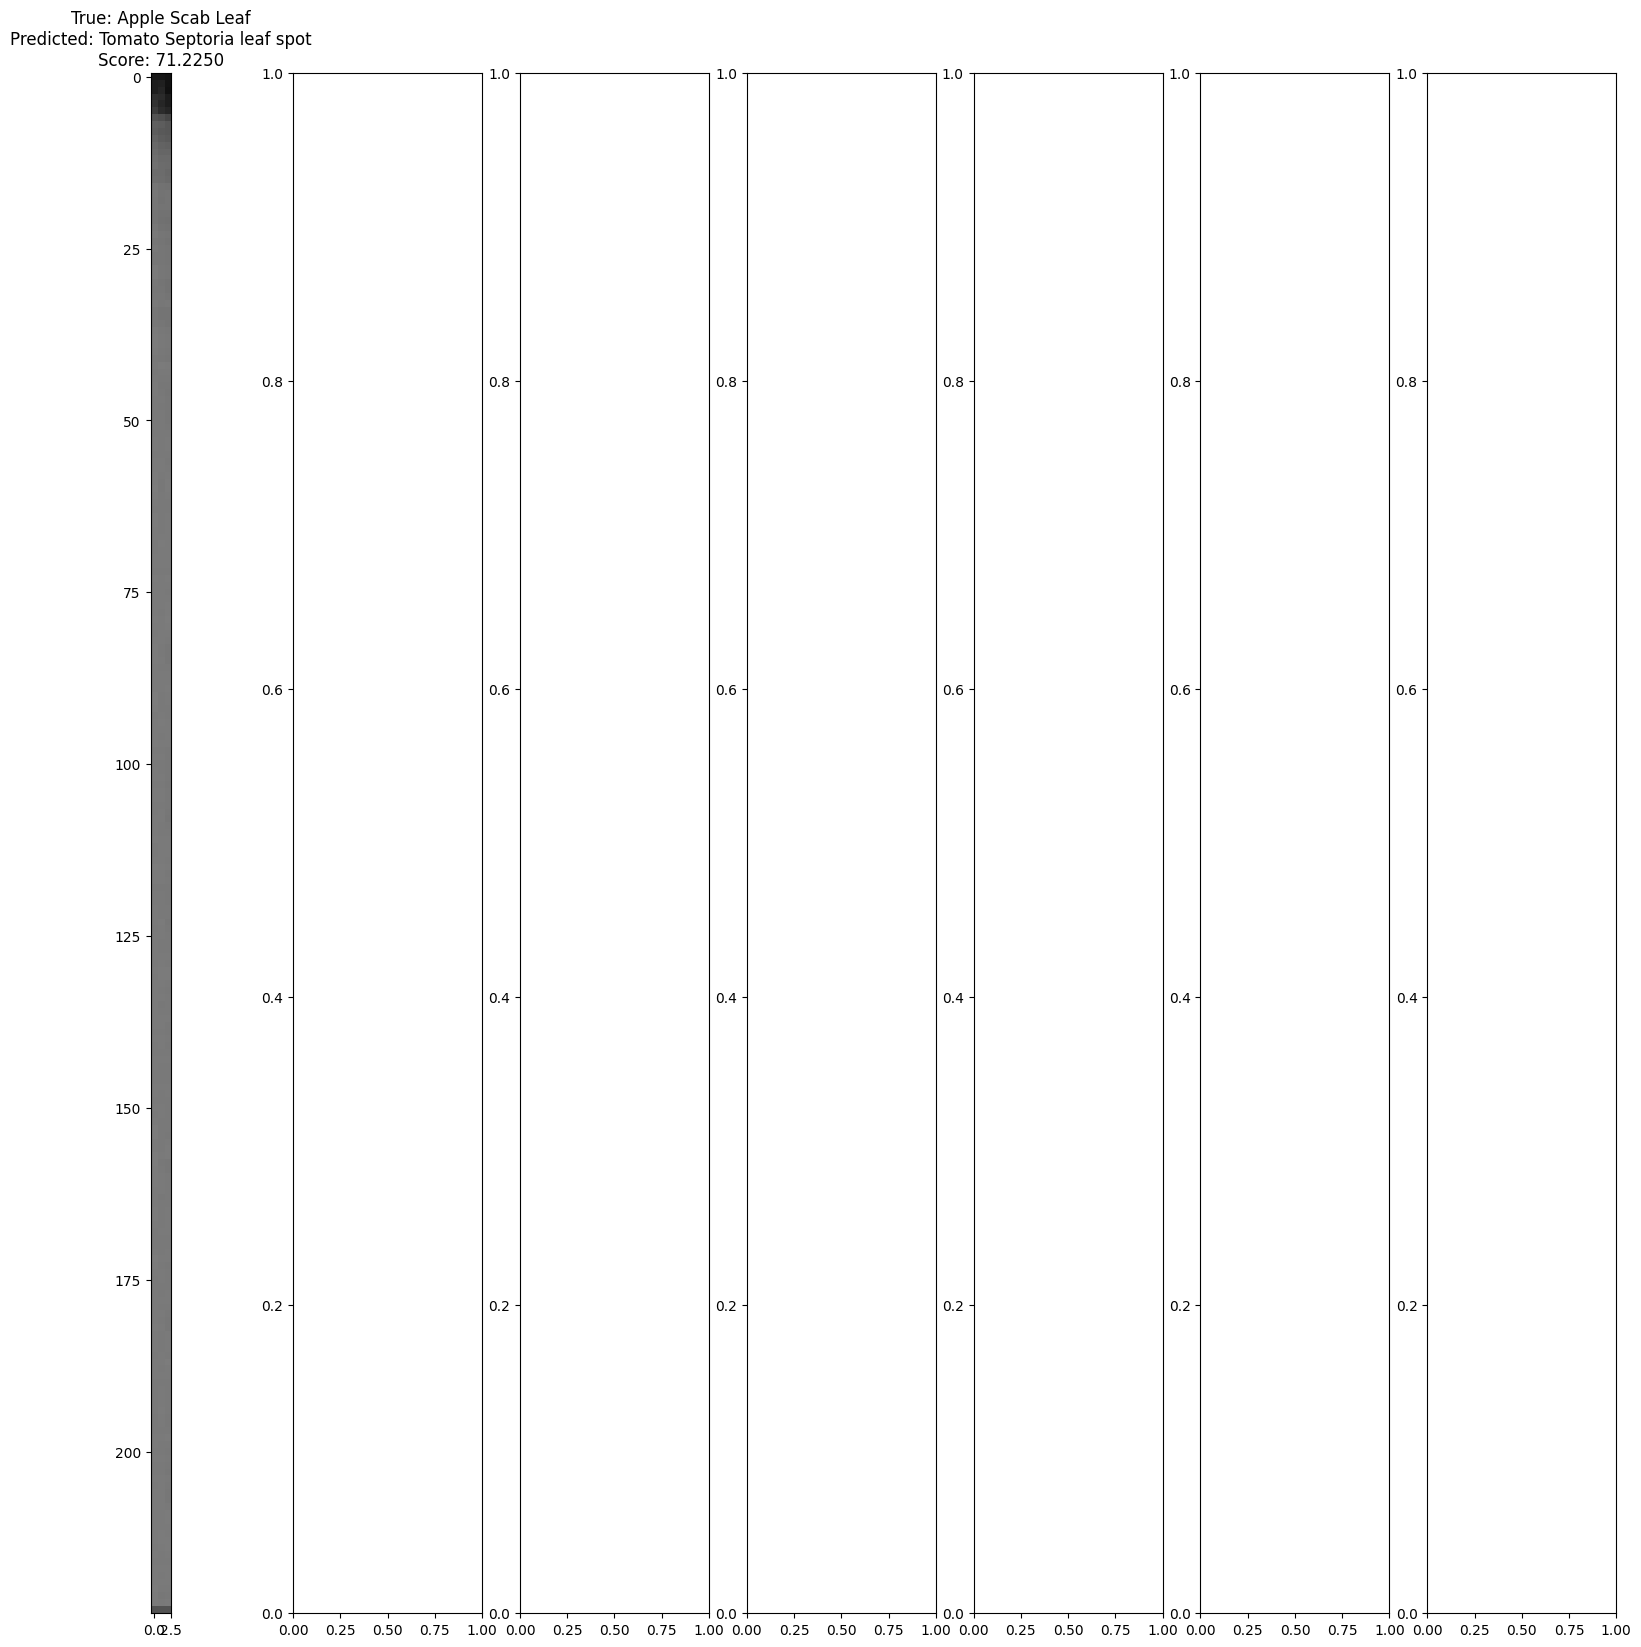

In [ ]:
import cv2
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, LayerCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

vit_model.eval()
target_layers = [vit_model.encoder.layers[3]]
cam_methods = [GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, LayerCAM]

# Loop through all classes
for class_name, samples in incorrect_samples.items():

    # Loop through incorrectly classified samples for each class
    for sample in samples:
        img_tensor, predicted_label, score = sample

    # Move to CPU and unsqueeze if necessary
    img_tensor = img_tensor.to(device).unsqueeze(0)
    original_img = img_tensor[0].cpu().permute(1, 2, 0).numpy()
    original_img = (original_img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])) * 255
    original_img = original_img.astype(np.float32) / 255.0

    fig, axs = plt.subplots(1, len(cam_methods) + 1, figsize=(20, 20))

    # Display original image
    axs[0].imshow(cv2.cvtColor(original_img[0], cv2.COLOR_BGR2RGB))
    axs[0].title.set_text(f"True: {class_name}\nPredicted: {predicted_label}\nScore: {score:.4f}")

    # Generate and store each CAM
    for idx, method in enumerate(cam_methods):
        cam = method(vit_model, target_layers, use_cuda=img_tensor.is_cuda)
        grayscale_cam = cam(img_tensor, None)
        # Normalize grayscale_cam to 0-1 range.
        grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())
        # Reshape grayscale_cam to 2D array
        grayscale_cam = grayscale_cam.reshape((grayscale_cam.shape[1], grayscale_cam.shape[2]))
        cam_image = show_cam_on_image(original_img, grayscale_cam)
        axs[idx+1].imshow(cv2.cvtColor(cam_image, cv2.COLOR_BGR2RGB))
        axs[idx+1].title.set_text(f'{method.__name__} Image')

    plt.show()